In [1]:
import functools
import glob
import os
import pandas as pd
import numpy as np

from IPython.core.display import HTML

# Data

### Global data (CSSE)

Cumulative

In [2]:
world = pd.concat(map(functools.partial(pd.read_csv), glob.glob('data/csse_covid19_daily_reports/*.csv')), sort=True)

In [3]:
# Date col names changed at some point
country_cols = ['Country/Region', 'Country_Region']
world['Country'] = world[country_cols].apply(lambda x: ','.join(x.dropna()), axis=1)

In [4]:
# Subset countries for comparison (and run stuff quick)
world = world[world['Country'].isin(['South Korea','Italy'])] # Gonna leave out Mexico for now... 

In [5]:
# Country col names changed at some point
date_cols = ['Last Update', 'Last_Update']
world['Last_Updated'] = world[date_cols].apply(lambda x: ','.join(x.dropna()), axis=1)

In [6]:
# Set date index
world = world.set_index(pd.DatetimeIndex(world['Last_Updated'])).sort_index() # Set ascending date

In [7]:
# Clean up
world = world.drop(['Last_Updated'], axis=1)

In [8]:
# Resample by daily and group by country
world = world.groupby('Country').resample('1D').mean().round()

In [9]:
# Subset
world = world[['Confirmed']]

### Tables

Pivot and transpose

In [10]:
df_world = world.reset_index().pivot('Country','Last_Updated','Confirmed').rename_axis(None).T

In [11]:
display(HTML(df_world.to_html()))

,Italy,South Korea
Last_Updated,,
2020-01-22,NaN,1.0
2020-01-23,NaN,1.0
2020-01-24,NaN,2.0
2020-01-25,NaN,2.0
2020-01-26,NaN,3.0
2020-01-27,NaN,4.0
2020-01-28,NaN,4.0
2020-01-29,NaN,4.0
2020-01-30,NaN,4.0


### Mexico Data (Secretaría de Salud)

Cumulative

In [21]:
mexico = pd.read_csv('data/time_series/mexico_total_daily_cases.csv')

In [22]:
mexico = mexico.set_index(pd.DatetimeIndex(mexico['Date_Confirmed'])).sort_index()

In [23]:
mexico.drop('Date_Confirmed', axis=1, inplace=True)

In [24]:
mexico['Mexico'] = mexico.sum(axis=1)

In [25]:
df_mexico = mexico[['CIUDAD DE MÉXICO','JALISCO','NUEVO LEÓN','Mexico']]

In [26]:
df_mexico = df_mexico.reset_index(inplace=False)

In [27]:
df_mexico = df_mexico.rename(columns={'Date_Confirmed':'Last_Updated'})

In [28]:
df_mexico = df_mexico.set_index(pd.DatetimeIndex(df_mexico['Last_Updated'])).sort_index()

In [29]:
df_mexico.tail()

,Last_Updated,CIUDAD DE MÉXICO,JALISCO,NUEVO LEÓN,Mexico
Last_Updated,,,,,
2020-03-28,2020-03-28,178.0,83.0,NaN,681.0
2020-03-29,2020-03-29,197.0,84.0,67.0,912.0
2020-03-30,2020-03-30,206.0,91.0,75.0,981.0
2020-03-31,2020-03-31,234.0,95.0,76.0,1125.0
2020-04-01,2020-04-01,298.0,101.0,78.0,1305.0


### Merge Tables

In [32]:
dfs = [df_world, df_mexico]
cum_tbl = pd.concat(dfs, sort=True).drop('Last_Updated', axis=1)

In [33]:
cum_tbl = cum_tbl.resample('1D').mean().round()

In [34]:
cum_tbl

,CIUDAD DE MÉXICO,Italy,JALISCO,Mexico,NUEVO LEÓN,South Korea
Last_Updated,,,,,,
2020-01-22,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-23,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-24,NaN,NaN,NaN,NaN,NaN,2.0
2020-01-25,NaN,NaN,NaN,NaN,NaN,2.0
2020-01-26,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...
2020-03-28,178.0,92472.0,83.0,681.0,NaN,NaN
2020-03-29,197.0,97689.0,84.0,912.0,67.0,NaN
2020-03-30,206.0,NaN,91.0,981.0,75.0,NaN


In [35]:
# Plots

from numpy import *
import math
import matplotlib.pyplot as plt

#cum_tbl = cum_tbl[(cum_tbl.index > '2020-03-10') & (cum_tbl.index <= '2020-03-29')]
#cum_tbl.fillna(0).cumsum().plot(figsize=(20,10))

# Bottom line

In [42]:
# Cumulative cases
cum_tbl.reset_index(drop=True, inplace=True)

In [43]:
# Calculate new cases
daily_tbl = cum_tbl.diff().fillna(cum_tbl).reset_index().drop('index', axis=1)

new_cases_tbl = daily_tbl._get_numeric_data()
new_cases_tbl[new_cases_tbl < 0] = 0

In [44]:
display(HTML(cum_tbl.to_html()))

,CIUDAD DE MÉXICO,Italy,JALISCO,Mexico,NUEVO LEÓN,South Korea
0,4.0,14195.0,NaN,7.0,1.0,NaN
1,NaN,NaN,NaN,5.0,NaN,NaN
2,10.0,NaN,NaN,17.0,NaN,NaN
3,16.0,22952.0,2.0,29.0,3.0,NaN
4,17.0,NaN,NaN,42.0,5.0,NaN
5,20.0,27980.0,NaN,68.0,13.0,NaN
6,NaN,31506.0,5.0,46.0,14.0,NaN
7,23.0,35713.0,6.0,77.0,19.0,NaN
8,30.0,41035.0,22.0,109.0,NaN,NaN
9,31.0,47021.0,28.0,155.0,29.0,NaN


In [45]:
display(HTML(new_cases_tbl.to_html()))

,CIUDAD DE MÉXICO,Italy,JALISCO,Mexico,NUEVO LEÓN,South Korea
0,4.0,14195.0,NaN,7.0,1.0,NaN
1,NaN,NaN,NaN,0.0,NaN,NaN
2,10.0,NaN,NaN,12.0,NaN,NaN
3,6.0,22952.0,2.0,12.0,3.0,NaN
4,1.0,NaN,NaN,13.0,2.0,NaN
5,3.0,27980.0,NaN,26.0,8.0,NaN
6,NaN,3526.0,5.0,0.0,1.0,NaN
7,23.0,4207.0,1.0,31.0,5.0,NaN
8,7.0,5322.0,16.0,32.0,NaN,NaN
9,1.0,5986.0,6.0,46.0,29.0,NaN


KeyError: 'Mainland China'

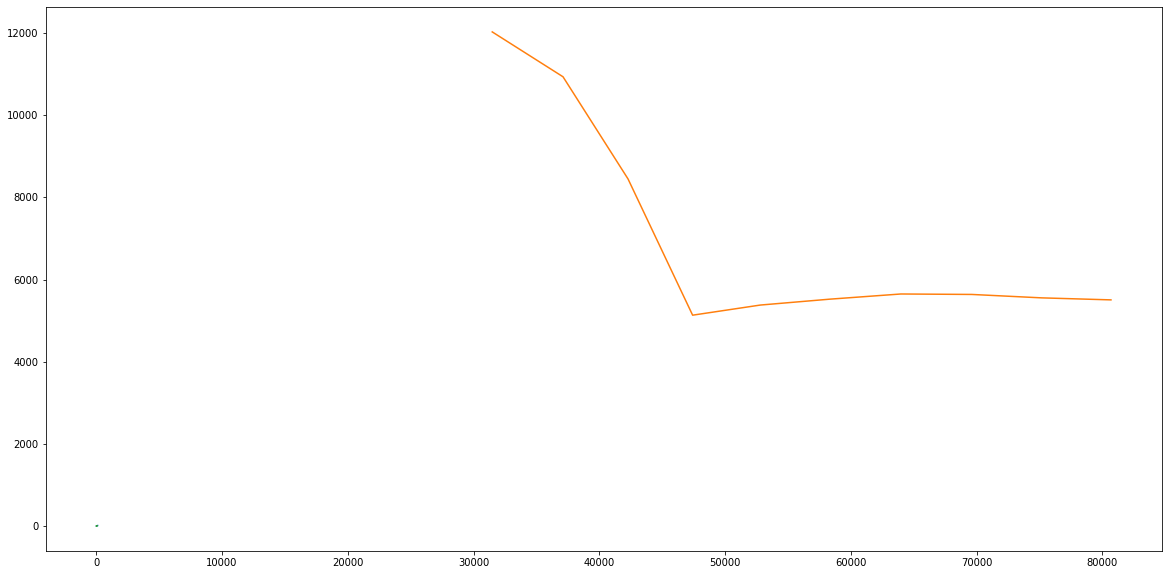

In [46]:
state_lane = {}

plt.figure(figsize=(20,10))

for region in ['CIUDAD DE MÉXICO', 'Italy', 'JALISCO', 'Mexico',
       'Mexico_SS', 'NUEVO LEÓN', 'South Korea', 'US']:
    plt.plot(list(cum_tbl[region].dropna().rolling(window=7).mean()), list(new_cases_tbl[region].dropna().rolling(window=7).mean()), label=region) 
    #pd.DataFrame(list(pivot_tbl_cum[state].dropna()), list(pivot_tbl_delta[state].dropna())).to_csv('data/output_series/' + state + '.csv')

plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.show()

In [410]:
#cum_tbl = cum_tbl[(cum_tbl.index > '2020-03-16') & (cum_tbl.index <= '2020-04-01')]

In [411]:
cum_tbl

,CIUDAD DE MÉXICO,Italy,JALISCO,Mainland China,Mexico,Mexico_SS,NUEVO LEÓN,South Korea,US
2020-03-17,NaN,31506.0,5.0,NaN,82.0,46.0,14.0,NaN,202.0
2020-03-18,23.0,35713.0,6.0,NaN,93.0,77.0,19.0,NaN,138.0
2020-03-19,30.0,41035.0,22.0,NaN,118.0,109.0,NaN,NaN,152.0
2020-03-20,31.0,47021.0,28.0,NaN,164.0,155.0,29.0,NaN,425.0
2020-03-21,45.0,53578.0,32.0,NaN,203.0,212.0,32.0,NaN,622.0
2020-03-22,56.0,59138.0,41.0,NaN,251.0,241.0,35.0,NaN,11.0
2020-03-23,60.0,63927.0,46.0,NaN,316.0,278.0,40.0,NaN,14.0
2020-03-24,66.0,69176.0,NaN,NaN,367.0,218.0,52.0,NaN,17.0
2020-03-25,82.0,74386.0,NaN,NaN,405.0,294.0,NaN,NaN,21.0
2020-03-26,83.0,80589.0,65.0,NaN,475.0,536.0,57.0,NaN,26.0
